In [ ]:
from qiskit_machine_learning.datasets.dataset_helper import (
    features_and_labels_transform
)

from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer

from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import matplotlib.pyplot as plt

In [ ]:
"""
breast cancer dataset
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit.utils import optionals
from qiskit_machine_learning.datasets.dataset_helper import (features_and_labels_transform)



# train_size=20
# test_size=30
# n=2
# plot_data=True
# one_hot=True


def reduce_data(train_size=0.7,dataset=None,test_size=0.3,dimension=2,plot_data=True,one_hot=False,
                sample_train=None, sample_test=None, label_train=[], label_test=None,title="Sample Diagram"):
    
    if len(dataset)>0:
        data =dataset["data"]
        target = dataset["target"]
        class_labels = np.unique(target).tolist()
        sample_train, sample_test, label_train, label_test = train_test_split(
            data, target, train_size=train_size,test_size=test_size, random_state=12)
    else:
        class_labels = np.unique(label_train).tolist()
        
    if type(test_size)==float or type(train_size)==float :
        test_size=len(label_test)
        train_size=len(label_train)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=dimension).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {
        key: (sample_train[label_train == k, :])[:train_size]
        for k, key in enumerate(class_labels)
    }
    test_input = {
        key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)
    }
    training_feature_array, training_label_array = features_and_labels_transform(
        training_input, class_labels, one_hot
    )
    test_feature_array, test_label_array = features_and_labels_transform(
        test_input, class_labels, one_hot
    )

    if plot_data:
        # optionals.HAS_MATPLOTLIB.require_now("breast_cancer")
        # pylint: disable=import-error
        import matplotlib.pyplot as plt

        for k in range(0, 2):
            #gets the xy cordinateds for each classes
            plt.scatter(
                sample_train[label_train == k, 0][:train_size],
                sample_train[label_train == k, 1][:train_size],
            )
        plt.legend(class_labels)
        plt.title(f"PCA dim.{dimension} reduced {title} dataset")
        plt.show()

    return(
        training_feature_array,
        training_label_array,
        test_feature_array,
        test_label_array)

# Pegasos Quantum Support Vector Classifier¶


In [ ]:
dataset=load_breast_cancer()

# Hyperopt Optimization

In [ ]:
# !pip install hyperopt 

In [ ]:
from hyperopt.pyll.base import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope

In [ ]:
# space = {"c": hp.uniform("c", -10, 10)}
# scope.int(hp.quiniform('my_param', 1, 100, q=1))


space ={"feature_dim":hp.choice("feature_dim",list(range(2,4))),
          "tau":hp.choice("tau",list(range(100,2000,200))),
       "C":hp.choice("C",list(range(1000,5000,200)))}

# define objective function
def model(params):
    # model_clf = SeasonalAD(**params)
    
    feature_dim = params["feature_dim"]
    
    # number of qubits is equal to the number of features
    num_qubits = feature_dim

    # number of steps performed during the training procedure
    tau = params["tau"]

    # regularization parameter
    C = params["C"]
    print(f'Dimen:{feature_dim}, Qbit:{num_qubits}, tau: {tau}, C:{C}')

    train_features,train_labels,test_features,test_labels = reduce_data(dataset=dataset,
                                                                  train_size=0.7,
                                                                  test_size=0.3,
                                                                  dimension=feature_dim,
                                                                  plot_data=False,
                                                                  one_hot=False,
                                                                  title="Breast Cancer SK learn")
    algorithm_globals.random_seed = 12345
    feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)
    # training
    # pegasos_qsvc.fit(train_features, train_labels)
    # testing
    # pegasos_score = pegasos_qsvc.score(test_features, test_labels)
    # print(f"PegasosQSVC classification test score: {pegasos_score}")
    return pegasos_qsvc,train_features,train_labels,test_features,test_labels

def hyperparameter_tuning(params):
    clf,train_features,train_labels,test_features,test_labels = model(params)
    clf.fit(train_features, train_labels)

    score = clf.score(test_features, test_labels)
 
    return {"loss": -1 * score, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    early_stop_fn=no_progress_loss(iteration_stop_count=10,
                                   percent_increase=0.0),
)

Dimen:2, Qbit:2, tau: 1300, C:1400                                                                                 
Dimen:3, Qbit:3, tau: 900, C:1000                                                                                  
Dimen:3, Qbit:3, tau: 1900, C:4400                                                                                 
Dimen:2, Qbit:2, tau: 300, C:3400                                                                                  
Dimen:3, Qbit:3, tau: 100, C:4600                                                                                  
Dimen:3, Qbit:3, tau: 1900, C:1600                                                                                 
Dimen:2, Qbit:2, tau: 1300, C:4800                                                                                 
Dimen:2, Qbit:2, tau: 1100, C:2200                                                                                 
100%|██████████████████████████████████████████| 10/10 [25:29<00:00, 152

In [ ]:
best

{'C': 6, 'feature_dim': 0, 'tau': 5}

In [ ]:
list(trials)

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.9005847953216374, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'C': [0], 'feature_dim': [0], 'tau': [0]},
   'vals': {'C': [2], 'feature_dim': [0], 'tau': [6]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 12, 4, 1, 46, 24, 714000),
  'refresh_time': datetime.datetime(2022, 12, 4, 1, 49, 12, 122000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.9122807017543859, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'C': [1], 'feature_dim': [1], 'tau': [1]},
   'vals': {'C': [0], 'feature_dim': [1], 'tau': [4]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 12, 4, 1, 49, 12, 127000),
  'refresh_time': datetime.datetime(2022, 12, 4, 1, 51, 24, 633000)},
 {'state': 2,


In [ ]:
space_final ={"feature_dim":list(range(2,4)),
         "tau":list(range(100,2000,200)),
    "C":list(range(1000,5000,200))}

In [ ]:
print(f'C:{space_final["C"][best["C"]]} , feature_dim: {space_final["feature_dim"][best["feature_dim"]]}, tau: {space_final["tau"][best["tau"]]} ')

C:2200 , feature_dim: 2, tau: 1100 


In [ ]:
feature_dim = space_final["feature_dim"][best["feature_dim"]]
# number of qubits is equal to the number of features
num_qubits = feature_dim

# number of steps performed during the training procedure
tau = space_final["tau"][best["tau"]]

# regularization parameter
C = space_final["C"][best["C"]]


train_features,train_labels,test_features,test_labels = reduce_data(dataset=dataset,
                                                                  train_size=0.7,
                                                                  test_size=0.3,
                                                                  dimension=feature_dim,
                                                                  plot_data=False,
                                                                  one_hot=False,
                                                                  title="Breast Cancer SK learn")
algorithm_globals.random_seed = 12345
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
qkernel = FidelityQuantumKernel(feature_map=feature_map)
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)
# training
pegasos_qsvc.fit(train_features, train_labels)
# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 0.9415204678362573


### Plotting predictions and wrong points

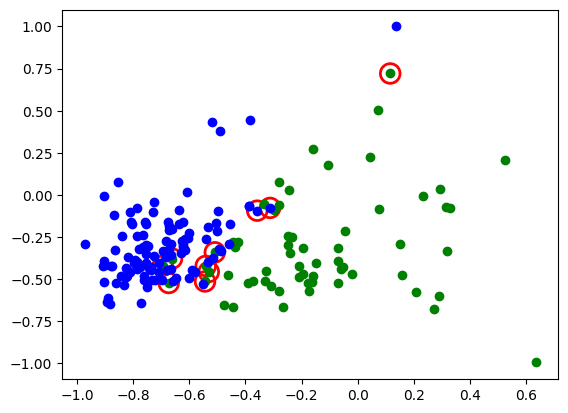

In [47]:
# evaluate data points
y_predict = pegasos_qsvc.predict(test_features)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_features, test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
# plt.legend(["Class 1","Class 0", "Wrongly classified"])
plt.savefig("./pqsvc.png")
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report

target_names = ["Class 1","Class 0"]
report=classification_report(y_true=test_labels, y_pred=y_predict, target_names=target_names,output_dict=True)

In [ ]:
print(classification_report(y_true=test_labels, y_pred=y_predict, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.97      0.88      0.92        64
     Class 0       0.93      0.98      0.95       107

    accuracy                           0.94       171
   macro avg       0.95      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



In [50]:
# plot confusion matrix: reference: 
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.savefig("./CP.png")

In [51]:
cm=confusion_matrix(y_true=test_labels, y_pred=y_predict)

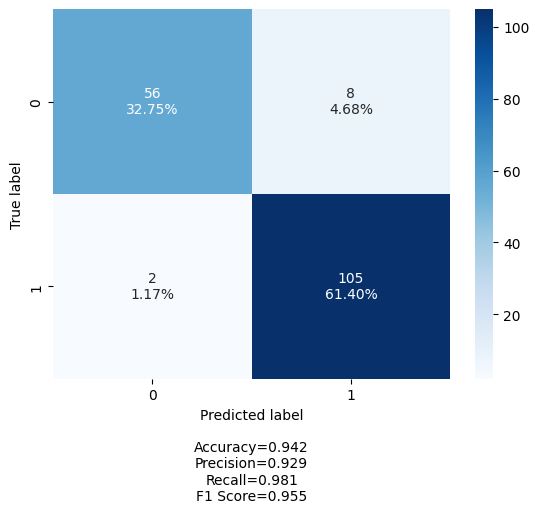

In [52]:
make_confusion_matrix(cm)